In [19]:
import pandas as pd
import numpy as np
import re
import math
import tldextract
from urllib.parse import urlparse, parse_qs
from collections import Counter
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import entropy
import warnings
warnings.filterwarnings('ignore')

In [20]:
DATA_PROC = Path("../data/processed")
DATA_FEAT = Path('../data/features')
DATA_FEAT.mkdir(parents=True, exist_ok=True)

In [22]:
df = pd.read_parquet(DATA_PROC / 'enhanced_urls.parquet')

In [26]:
df.shape, df.columns

((641119, 11),
 Index(['url', 'type', 'label', 'url_length', 'domain', 'has_https',
        'special_char_count', 'digit_count', 'tld', 'path_depth',
        'subdomain_count'],
       dtype='object'))

# feature engineering functions

In [27]:
def extract_query_features(url):
    """query and parameter feature extraction"""
    try:
        parsed = urlparse(url)
        query = parsed.query
        fragment = parsed.fragment
        
        # query features
        query_length = len(query) if query else 0
        fragment_length = len(fragment) if fragment else 0
        num_params = len(parse_qs(query)) if query else 0
        
        # parameter length
        max_param_length = 0
        if query:
            params = parse_qs(query)
            for key, values in params.items():
                max_param_length = max(max_param_length, len(key))
                for value in values:
                    max_param_length = max(max_param_length, len(value))
        
        return {
            'query_length': query_length,
            'fragment_length': fragment_length,
            'num_params': num_params,
            'max_param_length': max_param_length
        }
    except:
        return {
            'query_length': 0,
            'fragment_length': 0,
            'num_params': 0,
            'max_param_length': 0
        }

In [28]:
query_features = df['url'].apply(extract_query_features).apply(pd.Series)
df = pd.concat([df, query_features], axis=1)

In [29]:
query_features.columns, df.shape

(Index(['query_length', 'fragment_length', 'num_params', 'max_param_length'], dtype='object'),
 (641119, 15))

In [35]:
def calculate_entropy(text):
    """calculate Shannon entropy"""
    if not text or pd.isna(text):
        return 0
    freq = Counter(text)
    length = len(text)
    if length <= 1:
        return 0
    entropy_val = -sum((count/length) * math.log2(count/length) for count in freq.values())
    return entropy_val


In [36]:
def extract_lexical_features(url):
    """extract lexical and character-based features"""
    if not url or pd.isna(url):
        return {
            'entropy': 0,
            'vowel_consonant_ratio': 0,
            'char_repeat_ratio': 0,
            'uppercase_ratio': 0,
            'special_char_ratio': 0,
            'digit_ratio': 0
        }
    
    url_len = len(url)
    
    # Entropy
    entropy = calculate_entropy(url)
    
    # Character ratios
    vowels = len(re.findall(r'[aeiouAEIOU]', url))
    consonants = len(re.findall(r'[bcdfghjklmnpqrstvwxyzBCDFGHJKLMNPQRSTVWXYZ]', url))
    vowel_consonant_ratio = vowels / (consonants + 1)
    
    # Character repetition
    char_counts = Counter(url.lower())
    repeated_chars = sum(1 for count in char_counts.values() if count > 1)
    char_repeat_ratio = repeated_chars / url_len
    
    # Case analysis
    uppercase_count = sum(1 for c in url if c.isupper())
    uppercase_ratio = uppercase_count / url_len
    
    # Calculate special char and digit ratios directly (avoid DataFrame lookup!)
    special_chars = len(re.findall(r'[^a-zA-Z0-9]', url))
    digits = len(re.findall(r'\d', url))
    
    special_char_ratio = special_chars / url_len if url_len > 0 else 0
    digit_ratio = digits / url_len if url_len > 0 else 0
    
    return {
        'entropy': entropy,
        'vowel_consonant_ratio': vowel_consonant_ratio,
        'char_repeat_ratio': char_repeat_ratio,
        'uppercase_ratio': uppercase_ratio,
        'special_char_ratio': special_char_ratio,
        'digit_ratio': digit_ratio
    }

In [37]:
lexical_features = df['url'].apply(extract_lexical_features_optimized).apply(pd.Series)
df = pd.concat([df, lexical_features], axis=1)

In [38]:
lexical_features.columns, df.shape

(Index(['entropy', 'vowel_consonant_ratio', 'char_repeat_ratio',
        'uppercase_ratio', 'special_char_ratio', 'digit_ratio'],
       dtype='object'),
 (641119, 21))

# word based features

In [39]:
def extract_word_features(url):
    if not url or pd.isna(url):
        return {
            'word_count': 0,
            'avg_word_length': 0,
            'longest_word_length': 0
        }
    
    # Extract alphabetic words
    words = re.findall(r'[a-zA-Z]+', url)
    
    if not words:
        return {
            'word_count': 0,
            'avg_word_length': 0,
            'longest_word_length': 0
        }
    
    word_count = len(words)
    avg_word_length = sum(len(word) for word in words) / word_count
    longest_word_length = max(len(word) for word in words)
    
    return {
        'word_count': word_count,
        'avg_word_length': avg_word_length,
        'longest_word_length': longest_word_length
    }

In [40]:
word_features = df['url'].apply(extract_word_features).apply(pd.Series)
df = pd.concat([df, word_features], axis=1)

In [43]:
word_features.columns, df.shape

(Index(['word_count', 'avg_word_length', 'longest_word_length'], dtype='object'),
 (641119, 24))

# Security issues indicators

In [46]:
SUSPICIOUS_TLDS = ['tk', 'ml', 'ga', 'cf', 'top', 'work', 'click', 'download', 'zip']
URL_SHORTENERS = ['bit.ly', 'tinyurl.com', 't.co', 'goo.gl', 'short.link', 'ow.ly']
SUSPICIOUS_KEYWORDS = ['secure', 'account', 'update', 'confirm', 'verify', 'suspend', 
                      'restricted', 'urgent', 'expire', 'activate', 'validate', 'alert']
BRAND_KEYWORDS = ['paypal', 'amazon', 'google', 'microsoft', 'apple', 'facebook', 
                 'bank', 'visa', 'mastercard', 'netflix', 'spotify']

In [47]:
def extract_security_features(url, tld):
    if not url or pd.isna(url):
        return {
            'has_ip': 0,
            'suspicious_tld': 0,
            'is_url_shortener': 0,
            'has_suspicious_words': 0,
            'has_brand_keywords': 0,
            'social_engineering_score': 0
        }
    
    url_lower = url.lower()
    
    # IP address detection
    ip_pattern = r'\b(?:[0-9]{1,3}\.){3}[0-9]{1,3}\b'
    has_ip = int(bool(re.search(ip_pattern, url)))
    
    # detect suspicious tld 
    suspicious_tld = int(tld.lower() in SUSPICIOUS_TLDS) if pd.notna(tld) else 0
    
    # url shortener
    is_url_shortener = int(any(shortener in url_lower for shortener in URL_SHORTENERS))
    
    # suspicious keywords
    has_suspicious_words = int(any(word in url_lower for word in SUSPICIOUS_KEYWORDS))
    
    # company keywords, could be case of impersonation
    has_brand_keywords = int(any(brand in url_lower for brand in BRAND_KEYWORDS))
    
    # social engineering 'score' (count of suspicious terms)
    se_words = ['urgent', 'expire', 'suspend', 'verify', 'confirm', 'secure', 'alert', 'warning']
    social_engineering_score = sum(1 for word in se_words if word in url_lower)
    
    return {
        'has_ip': has_ip,
        'suspicious_tld': suspicious_tld,
        'is_url_shortener': is_url_shortener,
        'has_suspicious_words': has_suspicious_words,
        'has_brand_keywords': has_brand_keywords,
        'social_engineering_score': social_engineering_score
    }

In [48]:
security_features = df.apply(lambda row: extract_security_features(row['url'], row['tld']), axis=1).apply(pd.Series)
df = pd.concat([df, security_features], axis=1)

In [49]:
security_features.columns, df.shape

(Index(['has_ip', 'suspicious_tld', 'is_url_shortener', 'has_suspicious_words',
        'has_brand_keywords', 'social_engineering_score'],
       dtype='object'),
 (641119, 30))

# Obfuscation detection features
Inspo: https://cloud.google.com/blog/topics/threat-intelligence/url-obfuscation-schema-abuse/

In [50]:
def extract_obfuscation_features(url):
    if not url or pd.isna(url):
        return {
            'hex_chars': 0,
            'percent_encoding': 0,
            'consecutive_dots': 0,
            'consecutive_hyphens': 0,
            'homograph_chars': 0
        }
    
    # hex encoding
    hex_pattern = r'%[0-9a-fA-F]{2}'
    hex_chars = len(re.findall(hex_pattern, url))
    
    # % encoding count
    percent_encoding = url.count('%')
    
    #consecutive specialcharacters
    consecutive_dots = len(re.findall(r'\.{2,}', url))
    consecutive_hyphens = len(re.findall(r'-{2,}', url))

    homographs = ['а', 'е', 'о', 'р', 'с', 'х', 'у'] 
    homograph_chars = sum(1 for char in url if char in homographs)
    
    return {
        'hex_chars': hex_chars,
        'percent_encoding': percent_encoding,
        'consecutive_dots': consecutive_dots,
        'consecutive_hyphens': consecutive_hyphens,
        'homograph_chars': homograph_chars
    }

In [51]:
obfuscation_features = df['url'].apply(extract_obfuscation_features).apply(pd.Series)
df = pd.concat([df, obfuscation_features], axis=1)

In [52]:
obfuscation_features.columns, df.shape

(Index(['hex_chars', 'percent_encoding', 'consecutive_dots',
        'consecutive_hyphens', 'homograph_chars'],
       dtype='object'),
 (641119, 35))

# Domain and Network Features

In [53]:
def extract_network_features(url, domain):
    if not url or pd.isna(url):
        return {
            'domain_entropy': 0,
            'domain_tokens': 0,
            'subdomain_length': 0,
            'has_port': 0,
            'port_number': 80,
            'is_https': 0
        }
    
    # entropy for domain
    domain_entropy = calculate_entropy(domain) if pd.notna(domain) else 0
    
    #domain tokens (split by dots and hyphens)
    domain_tokens = 0
    if pd.notna(domain):
        domain_tokens = len([token for token in re.split(r'[.-]', domain) if token])
    
    subdomain_length = 0
    try:
        extracted = tldextract.extract(url)
        subdomain_length = len(extracted.subdomain) if extracted.subdomain else 0
    except:
        pass
    
    #port analsis
    has_port = 0
    port_number = 80
    try:
        parsed = urlparse(url)
        if parsed.port:
            has_port = 1
            port_number = parsed.port
        elif parsed.scheme == 'https':
            port_number = 443
    except:
        pass
    
    # https detection again
    is_https = int(url.lower().startswith('https://'))
    
    return {
        'domain_entropy': domain_entropy,
        'domain_tokens': domain_tokens,
        'subdomain_length': subdomain_length,
        'has_port': has_port,
        'port_number': port_number,
        'is_https': is_https
    }

In [54]:
network_features = df.apply(lambda row: extract_network_features(row['url'], row['domain']), axis=1).apply(pd.Series)
df = pd.concat([df, network_features], axis=1)

In [55]:
network_features.columns, df.shape

(Index(['domain_entropy', 'domain_tokens', 'subdomain_length', 'has_port',
        'port_number', 'is_https'],
       dtype='object'),
 (641119, 41))

# pattern detection features

In [69]:
def extract_pattern_features(url):
    """Extract advanced pattern detection features"""
    if not url or pd.isna(url):
        return {
            'contains_date_pattern': 0,
            'contains_version_pattern': 0,
            'redirect_indicators': 0,
            'file_extension_count': 0
        }
    
    url_lower = url.lower()
    
    # Date patterns (might indicate time-sensitive attacks)
    date_patterns = [r'\d{4}', r'\d{2}-\d{2}', r'\d{2}_\d{2}', r'20\d{2}']
    contains_date_pattern = int(any(re.search(pattern, url) for pattern in date_patterns))
    
    # Version patterns
    version_pattern = r'v?\d+\.\d+'
    contains_version_pattern = int(bool(re.search(version_pattern, url)))
    
    # Redirect indicators
    redirect_words = ['redirect', 'goto', 'link', 'click', 'ref', 'track', 'forward']
    redirect_indicators = sum(1 for word in redirect_words if word in url_lower)
    
    # File extensions
    file_extensions = re.findall(r'\.[a-zA-Z0-9]{1,4}(?:/|$|\?)', url)
    file_extension_count = len(set(file_extensions))
    
    return {
        'contains_date_pattern': contains_date_pattern,
        'contains_version_pattern': contains_version_pattern,
        'redirect_indicators': redirect_indicators,
        'file_extension_count': file_extension_count
    }

In [70]:
pattern_features = df['url'].apply(extract_pattern_features).apply(pd.Series)
df = pd.concat([df, pattern_features], axis=1)

In [71]:
pattern_features.columns, df.shape

(Index(['contains_date_pattern', 'contains_version_pattern',
        'redirect_indicators', 'file_extension_count'],
       dtype='object'),
 (641119, 50))

# Feature summary / quality check

In [63]:
def analyse_feature_quality(df):
    
    numerical_features = df.select_dtypes(include=[np.number])
    feature_cols = [col for col in numerical_features.columns if col not in ['label']]
    
    print(f"Total features created: {len(feature_cols)}")
    print(f"Original dataset columns: url, label, type")
    print(f"New engineered features: {len(feature_cols) - 2}")  # -2 for original label and any index
    
    feature_categories = {
        'URL Structure': ['url_length', 'domain_length', 'path_depth', 'subdomain_count', 
                         'query_length', 'fragment_length', 'num_params'],
        'Character Analysis': ['special_char_count', 'digit_count', 'entropy', 'vowel_consonant_ratio',
                              'char_repeat_ratio', 'special_char_ratio', 'digit_ratio', 'uppercase_ratio'],
        'Word Analysis': ['word_count', 'avg_word_length', 'longest_word_length'],
        'Security Indicators': ['has_ip', 'suspicious_tld', 'is_url_shortener', 'has_suspicious_words',
                               'has_brand_keywords', 'social_engineering_score'],
        'Obfuscation': ['hex_chars', 'percent_encoding', 'consecutive_dots', 'consecutive_hyphens'],
        'Network Features': ['domain_entropy', 'domain_tokens', 'has_port', 'is_https'],
        'Ratios': ['domain_url_ratio', 'path_url_ratio', 'query_url_ratio', 'param_url_ratio'],
        'Patterns': ['contains_date_pattern', 'contains_version_pattern', 'redirect_indicators']
    }
    
    print(f"\nFeature Categories:")
    total_categorized = 0
    for category, features in feature_categories.items():
        existing_features = [f for f in features if f in df.columns]
        total_categorized += len(existing_features)
        print(f"  {category:20s}: {len(existing_features):2d} features")
    
    # missing values checking
    missing_features = numerical_features.isnull().sum()
    features_with_missing = missing_features[missing_features > 0]
    
    if len(features_with_missing) > 0:
        print(f"\nFeatures with missing values:")
        for feature, count in features_with_missing.items():
            print(f"  {feature}: {count} ({count/len(df)*100:.2f}%)")
    else:
        print(f"\n✓ No missing values in engineered features")
    
    print(f"\nFeature Value Ranges:")
    for category, features in list(feature_categories.items())[:3]:  # Show first 3 categories
        existing_features = [f for f in features if f in df.columns][:3]  # Show max 3 per category
        if existing_features:
            print(f"  {category}:")
            for feature in existing_features:
                min_val = df[feature].min()
                max_val = df[feature].max()
                mean_val = df[feature].mean()
                print(f"    {feature:20s}: [{min_val:8.3f}, {max_val:8.3f}] (μ={mean_val:6.3f})")


In [64]:
analyse_feature_quality(df)

Total features created: 40
Original dataset columns: url, label, type
New engineered features: 38

Feature Categories:
  URL Structure       :  6 features
  Character Analysis  :  8 features
  Word Analysis       :  3 features
  Security Indicators :  6 features
  Obfuscation         :  4 features
  Network Features    :  4 features
  Ratios              :  0 features
  Patterns            :  3 features

✓ No missing values in engineered features

Feature Value Ranges:
  URL Structure:
    url_length          : [   1.000, 2175.000] (μ=59.762)
    path_depth          : [   0.000,   39.000] (μ= 0.644)
    subdomain_count     : [   0.000,   33.000] (μ= 0.601)
  Character Analysis:
    special_char_count  : [   0.000,  372.000] (μ= 9.229)
    digit_count         : [   0.000, 1204.000] (μ= 5.372)
    entropy             : [   0.000,    7.504] (μ= 4.218)
  Word Analysis:
    word_count          : [   0.000,  309.000] (μ= 9.111)
    avg_word_length     : [   0.000,   61.171] (μ= 5.427)
    lo

# Feature correlation

In [65]:
def analyse_feature_correlations(df):
    numerical_features = df.select_dtypes(include=[np.number])
    feature_cols = [col for col in numerical_features.columns if col not in ['label']]
    
    # correlation with target
    correlations = numerical_features[feature_cols].corrwith(numerical_features['label'])
    correlations = correlations.abs().sort_values(ascending=False)
    
    print(f"\nTop 15 Most Predictive Features:")
    print("-" * 50)
    for i, (feature, corr) in enumerate(correlations.head(15).items(), 1):
        print(f"{i:2d}. {feature:25s}: {corr:.4f}")
    
    plt.figure(figsize=(12, 8))
    
    # Top 15 feature correlations
    top_correlations = correlations.head(15)
    
    bars = plt.bar(range(len(top_correlations)), top_correlations.values, 
                   color=plt.cm.viridis(np.linspace(0, 1, len(top_correlations))))
    
    plt.title('Top 15 Feature Correlations with Target', fontsize=14, fontweight='bold')
    plt.xlabel('Features')
    plt.ylabel('Absolute Correlation with Target')
    plt.xticks(range(len(top_correlations)), top_correlations.index, rotation=45, ha='right')
    
    for i, (bar, corr) in enumerate(zip(bars, top_correlations.values)):
        plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.005,
                f'{corr:.3f}', ha='center', va='bottom', fontsize=8)
    
    plt.tight_layout()
    plt.show()
    
    return correlations


Top 15 Most Predictive Features:
--------------------------------------------------
 1. num_params               : 0.4418
 2. path_depth               : 0.4198
 3. special_char_ratio       : 0.3319
 4. file_extension_count     : 0.3043
 5. query_length             : 0.2581
 6. special_char_count       : 0.2514
 7. vowel_consonant_ratio    : 0.2203
 8. subdomain_count          : 0.1944
 9. contains_date_pattern    : 0.1790
10. url_length_safe          : 0.1788
11. url_length               : 0.1788
12. entropy                  : 0.1686
13. has_ip                   : 0.1637
14. word_count               : 0.1427
15. contains_version_pattern : 0.1289


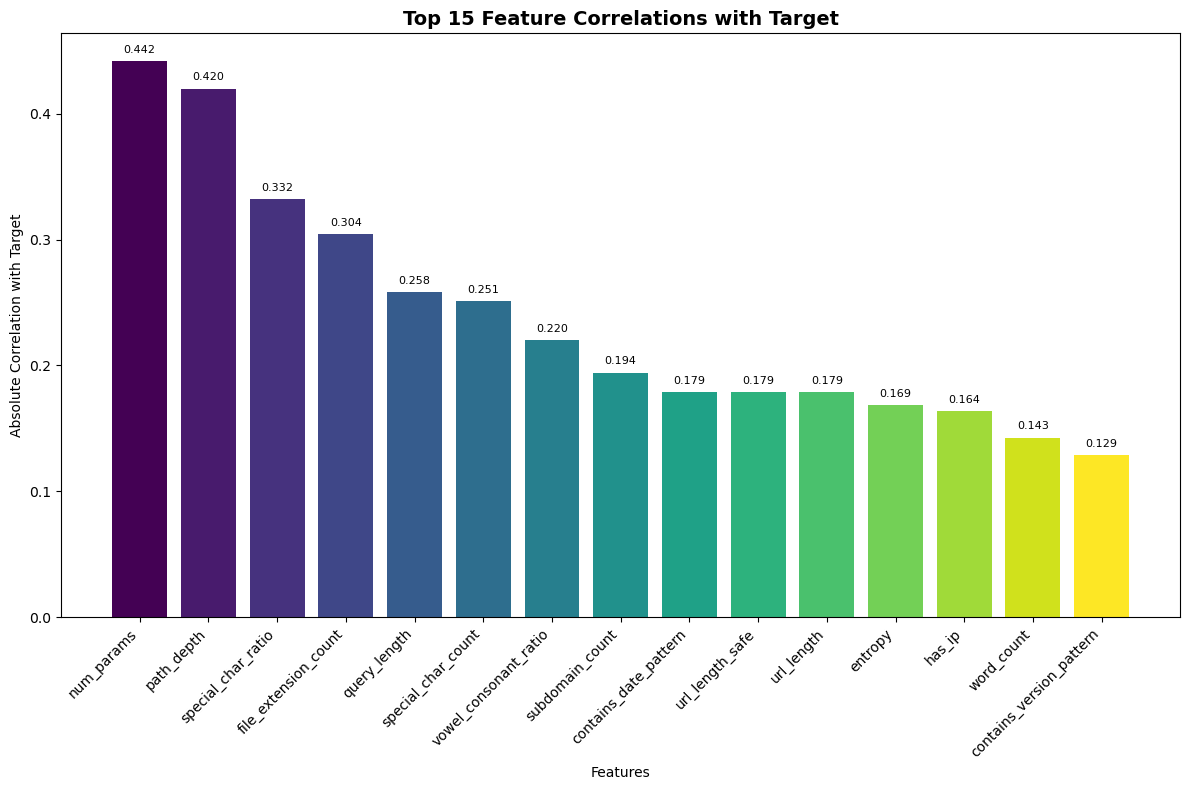

In [66]:
correlations = analyse_feature_correlations(df)

In [67]:
df = df.loc[:, ~df.columns.duplicated()]

In [68]:
df.to_parquet(DATA_FEAT / 'url_features_complete.parquet', index=False)